## Pure Planet - Analysis of Website Metrics

### Connor Goddard

**6th August 2018**

In [1]:
import numpy as np
import pandas as pd
import plotly.plotly as py
import utils
import matplotlib.pyplot as plt

utils.init_plotly(username='cgddrd', api_key='F7STNJas2eDGiBpOva9a')

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# df = pd.read_csv('../data/raw/ga.csv', header=0)
df = pd.read_csv('../data/raw/ga.csv', header=0, parse_dates=['date'], date_parser=utils.parse_csv_date, index_col='date')
df.head()

,category,metric,value
date,,,
2017-12-04,Branded Search,app_store,65
2017-12-04,Branded Search,complete_quote,437
2017-12-04,Branded Search,save_quote,165
2017-12-04,Branded Search,start_quote,491
2017-12-04,Branded Search,visitors,901


In [3]:
data = df.groupby(['metric'])['value'].sum().sort_values(ascending=False)
data = data[~data.index.str.contains("app_store")]

In [4]:
colors = ['rgb(32,155,160)', 
          'rgb(253,93,124)', 
          'rgb(28,119,139)', 
          'rgb(182,231,235)', 
          'rgb(35,154,160)', 
          'rgb(35,154,2)']

fig = utils.plot_funnel_chart(data, colors, 'Metrics Funnel')
py.iplot(fig)

In [5]:
metrics_by_channels = df.groupby(['metric', 'category'])["value"].sum().reset_index()

metrics_by_channels = metrics_by_channels.groupby('metric').apply(
    lambda f: f.groupby('category').apply(
        lambda g: g['value'].values
    ))

metrics_by_channels['sum'] = df.groupby('metric')['value'].sum()
metrics_by_channels.sort_values('sum', ascending=False, inplace=True)
totals = metrics_by_channels['sum'].values
metrics_by_channels.drop('sum', axis=1, inplace=True)

# remove any data for the 'app_store' metric. We aren't interested in this for the funnel chart.
metrics_by_channels = metrics_by_channels[~metrics_by_channels.index.str.contains("app_store")]

In [6]:
fig = utils.plot_stacked_funnel_chart(metrics_by_channels, totals, colors, 'Metrics by Channel Contribution Funnel')
py.iplot(fig)

In [7]:
# %matplotlib inline
# import matplotlib.pyplot as plt

# ind = np.arange(len(grouped_seg.index))

# plt.figure(figsize=(12, 12))
# width = 0.5   

# i = 0
# ny = len(grouped_seg[grouped_seg.columns[0]])
# cum_size = np.zeros(ny)

# for column in grouped_seg:
    
#     data = np.concatenate(grouped_seg[column].values, axis=0)
#     plt.bar(ind, data, width, bottom=cum_size, label=column)
    
#     cum_size += data

# plt.ylabel('No of Hits')
# plt.xticks(ind, grouped_seg.index)
# plt.legend()
# plt.show()

### Conversion by Week

In [8]:
df = pd.read_csv('../data/raw/ga.csv', header=0, parse_dates=['date'], date_parser=utils.parse_csv_date, index_col='date')

In [9]:
metrics = df[df['metric'] == 'visitors'].groupby(pd.Grouper(freq='W'))['value'].sum()
metrics = pd.DataFrame(metrics)
metrics['save_quote'] = df[df['metric'] == 'save_quote'].groupby(pd.Grouper(freq='W'))['value'].sum()
metrics.columns = ['visitors', 'save_quote']
metrics['conversion_rate'] = (metrics['save_quote'] / metrics['visitors']) * 100
metrics

,visitors,save_quote,conversion_rate
date,,,
2017-12-10,27384,2101,7.672363
2017-12-17,18917,1693,8.949622
2017-12-24,10009,1020,10.190828
2017-12-31,8717,1042,11.953654
2018-01-07,15611,1850,11.850618
2018-01-14,26225,3325,12.678742
2018-01-21,25298,2797,11.056210
2018-01-28,21526,2574,11.957633
2018-02-04,21944,1972,8.986511


In [10]:
%%capture captured
%matplotlib inline
plt.style.use('ggplot')
import matplotlib.dates as mdates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU

fig_conv_by_week, ax1 = plt.subplots(figsize=(12, 10))
ax1.bar(metrics.index, metrics['visitors'], width=2)

ax1.set_ylabel('visitors')
ax1.grid(False)

ax2 = ax1.twinx()

ax2.plot(metrics.index, metrics['conversion_rate'], 'b')

#set ticks every week (Sunday)
ax2.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=SU))

# set minor ticks to every day
ax2.xaxis.set_minor_locator(mdates.DayLocator())

#set major ticks format
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))

ax2.set_ylabel('conversion rate', color='b')
ax2.tick_params('y', colors='b')
ax2.set_ylim(bottom = 0, top = (ax2.get_ylim()[1] * 2))

# use ';' to suppress additional output.
plt.show();

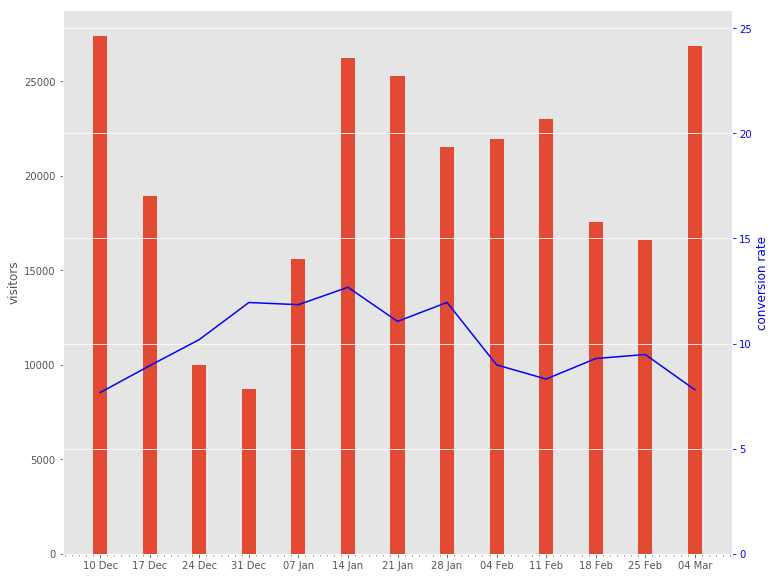

In [11]:
fig_conv_by_week

### How does quote conversion vary by channel?

* **Conversion is the rate of quote saves vs. visitors.**

In [12]:
df = pd.read_csv('../data/raw/ga.csv', header=0, parse_dates=['date'], date_parser=utils.parse_csv_date, index_col='date')

In [13]:
def calc_conversion_rate(visitors, save_quotes):
    return save_quotes/visitors * 100

metric_summaries_by_channel = df.groupby(['category', 'metric']).sum()

conversion_rates_by_channel = metric_summaries_by_channel.groupby(level=0) \
                                .apply(lambda x: calc_conversion_rate(x.loc[(x.name, 'visitors')], 
                                                      x.loc[(x.name, 'save_quote')]))
conversion_rates_by_channel

,value
category,
Branded Search,16.758545
Direct Traffic,2.467282
Generic Search,9.319679
Organic,11.934185
Paid search,6.427023
Referral link,28.259752


In [14]:
data = df.groupby(['category', 'metric'])["value"].sum().sort_values(ascending=False).reset_index()

data = data.groupby('metric').apply(
    lambda f: f.groupby('category').apply(
        lambda g: g['value'].values
    ))
data = data.T
data['sum'] = df.groupby('category')['value'].sum()
data = data.sort_values(by='sum', ascending=False)
data

metric,app_store,complete_quote,save_quote,start_quote,visitors,sum
category,,,,,,
Generic Search,[4231],[29696],[11003],[37415],[118062],200407
Paid search,[1361],[17662],[4300],[23565],[66905],113793
Referral link,[1361],[10383],[6049],[11900],[21405],51098
Direct Traffic,[793],[1427],[690],[1730],[27966],32606
Organic,[1328],[4604],[1719],[5264],[14404],27319
Branded Search,[637],[4543],[1824],[5223],[10884],23111


In [15]:
data.drop('sum', axis=1, inplace=True) 

In [16]:
conversion_rates_by_channel = conversion_rates_by_channel.reindex(data.index)
conversion_rates_by_channel

,value
category,
Generic Search,9.319679
Paid search,6.427023
Referral link,28.259752
Direct Traffic,2.467282
Organic,11.934185
Branded Search,16.758545


In [17]:
%%capture captured
import matplotlib.pyplot as plt

ind = np.arange(len(data.index))

fig_conv_by_channel, ax = plt.subplots(figsize=(12, 10))
width = 0.5   

i = 0
ny = len(data.index)
cum_size = np.zeros(ny)

# reverse the order of the columns to render 'visitors' column first.
for column in data.columns[::-1]:
    
    dat = np.concatenate(data[column].values, axis=0)
    ax.bar(ind, dat, width, bottom=cum_size, label=column)
    
    cum_size += dat

ax.set_ylabel('No of Hits')
ax.set_xticks(np.arange(len(data.index)))
ax.set_xticklabels(data.index)
ax.legend()

ax2 = ax.twinx()

ax2.plot(data.index, conversion_rates_by_channel.values, 'b')

ax2.set_ylabel('conversion rate', color='b')
ax2.tick_params('y', colors='b')
ax2.set_ylim(bottom = 0, top = (ax2.get_ylim()[1] * 2))

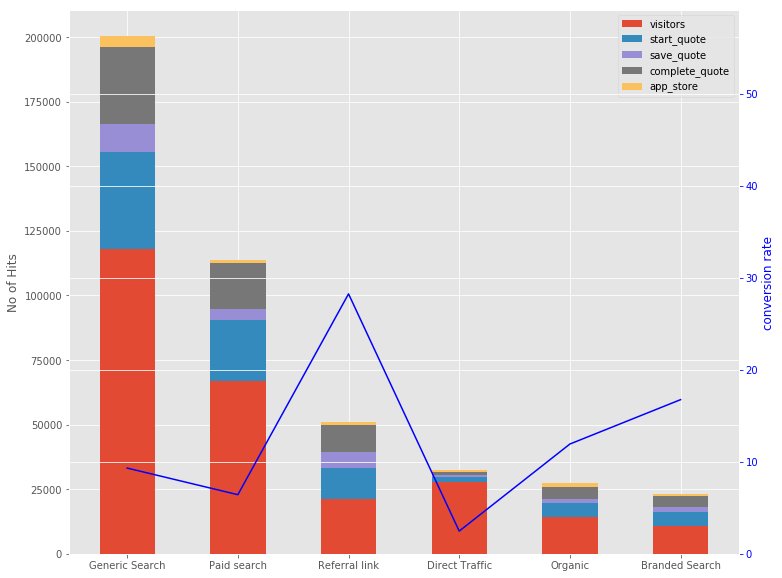

In [18]:
fig_conv_by_channel

### What was each channel’s contribution to app store visits and saved quotes over time?

In [19]:
df = pd.read_csv('../data/raw/ga.csv', header=0, parse_dates=['date'], date_parser=utils.parse_csv_date, index_col='date')

In [20]:
slimmed = df[(df['metric'] == 'app_store') | (df['metric'] == 'save_quote')]
weekly_totals = slimmed.groupby([pd.Grouper(freq='W'), 'metric'])['value'].sum()

In [21]:
categories = slimmed.groupby('metric')

# loop through weeks
weeks = slimmed.groupby(pd.Grouper(freq='W')).first().index

datf_list = list()

for name, group in categories:

    # group categories by weeks and then sum the metric counts.
    agg = group.groupby([pd.Grouper(freq='W'), 'category']).sum()
    p = agg.reset_index().pivot('date', 'category', 'value')
    datf_list.append(p)

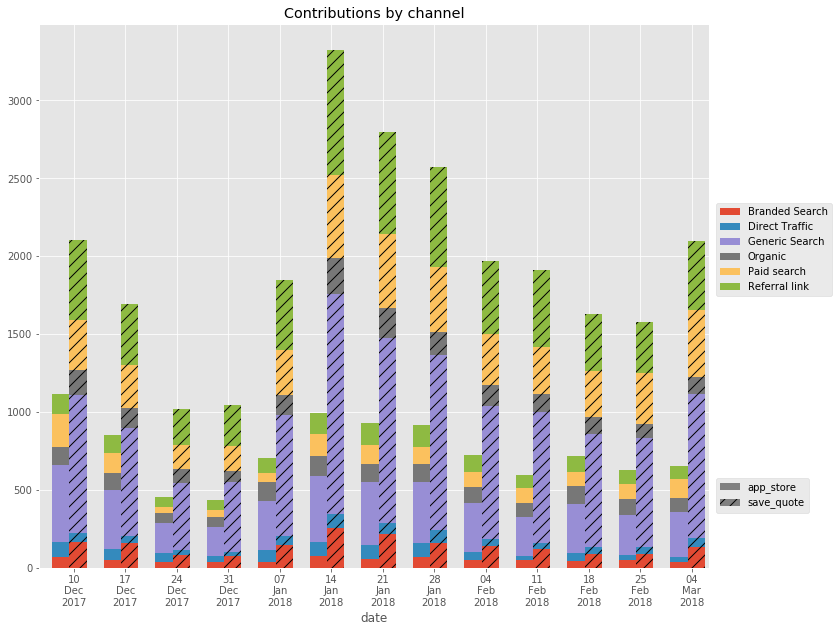

In [22]:
utils.plot_clustered_stacked(datf_list, ["app_store", "save_quote"], H='//', xfmt=utils.x_date_format, title='Contributions by channel');